In [1]:
import sys
import pandas as pd
from scipy import stats
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import requests
import datetime
import bt
from typing import Callable
import warnings

%matplotlib inline
pd.options.mode.chained_assignment = None 
warnings.simplefilter(action='ignore', category=FutureWarning)

Download data for Amazon 

In [2]:
data = yf.download('AMZN', start='2017-12-01', end='2022-12-31')
print(data)

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2017-12-01  58.602501  58.982498  57.599998  58.117500  58.117500   82142000
2017-12-04  58.692501  58.759998  56.400002  56.697498  56.697498  118638000
2017-12-05  56.412998  57.963501  56.237000  57.078499  57.078499   81596000
2017-12-06  56.899502  57.794498  56.804001  57.617500  57.617500   57066000
2017-12-07  57.829498  58.159500  57.549999  57.989498  57.989498   50232000
...               ...        ...        ...        ...        ...        ...
2022-12-23  83.250000  85.779999  82.930000  85.250000  85.250000   57433700
2022-12-27  84.970001  85.349998  83.000000  83.040001  83.040001   57284000
2022-12-28  82.800003  83.480003  81.690002  81.820000  81.820000   58228600
2022-12-29  82.870003  84.550003  82.550003  84.180000  84.180000   54995900
2022-12

Calculate Relative Strength Index (RSI) and Bollinger Bands (BB) indicators that will define conditions to enter a trade, using typical for mean-reversion strategy period of 14 days. 

In [3]:
#Bollinger Bands loopback
sma_20 = 20

#Calculate Bollinger Bands 
data['sma_20'] = data['Adj Close'].rolling(sma_20).mean()
data['std'] = data['Adj Close'].rolling(sma_20).std()
data['upper_bollinger'] = data['sma_20'] + (2 * data['std'])
data['lower_bollinger'] = data['sma_20'] - (2 * data['std'])

#RSI loopback
period = 14

#Calculate RSI
def calculate_rsi(prices: pd.Series, loopback: Callable):
    
    price_delta = prices.diff()
    price_delta = price_delta[1:] 
    
    gain, loss = price_delta.clip(lower=0), price_delta.clip(upper=0).abs()
    
    loopback_gain = loopback(gain)
    loopback_loss = loopback(loss)
    
    rs = loopback_gain/loopback_loss
    rsi = 100-(100/(rs+1))
    
    return rsi

rsi_ema = calculate_rsi(data['Adj Close'], lambda s: s.ewm(span=period).mean()) #exponential weighted moving average
rsi_sma = calculate_rsi(data['Adj Close'], lambda s: s.rolling(period).mean()) #simple moving average
rsi_rma = calculate_rsi(data['Adj Close'], lambda s: s.ewm(alpha=1/period).mean()) #modified/running moving average
data['rsi'] = rsi_sma
print(data)

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2017-12-01  58.602501  58.982498  57.599998  58.117500  58.117500   82142000   
2017-12-04  58.692501  58.759998  56.400002  56.697498  56.697498  118638000   
2017-12-05  56.412998  57.963501  56.237000  57.078499  57.078499   81596000   
2017-12-06  56.899502  57.794498  56.804001  57.617500  57.617500   57066000   
2017-12-07  57.829498  58.159500  57.549999  57.989498  57.989498   50232000   
...               ...        ...        ...        ...        ...        ...   
2022-12-23  83.250000  85.779999  82.930000  85.250000  85.250000   57433700   
2022-12-27  84.970001  85.349998  83.000000  83.040001  83.040001   57284000   
2022-12-28  82.800003  83.480003  81.690002  81.820000  81.820000   58228600   
2022-12-29  82.870003  84.550003  82.550003  84.180000  84.180000   54995900   
2022-12-30  83.120003  84.050003  82.470

Vizualize Bollinger Bands

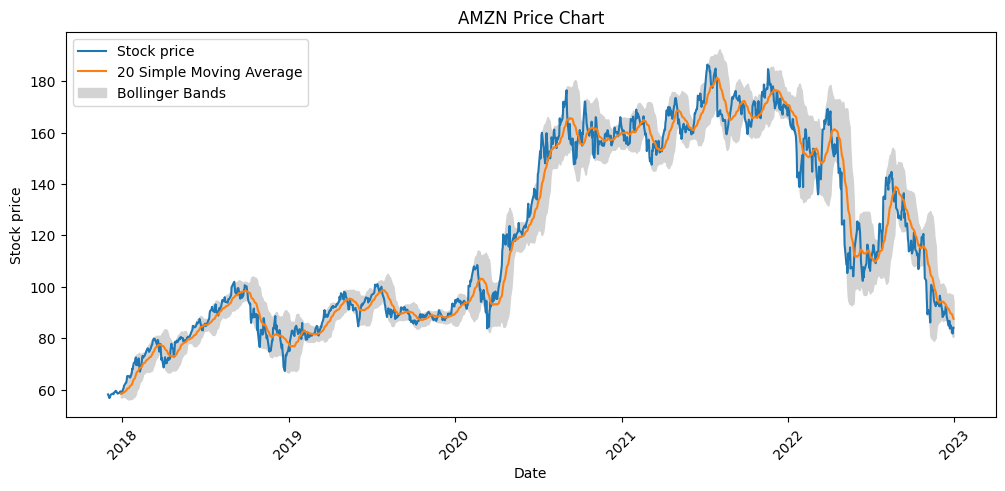

In [4]:
plt.figure(figsize=(12,5))

plt.plot(data.index, data['Adj Close'], label = 'Stock price')
plt.plot(data.index, data['sma_20'], label = '20 Simple Moving Average')
plt.fill_between(data.index, data['upper_bollinger'], data['lower_bollinger'], label = 'Bollinger Bands', color='lightgrey')
plt.title('AMZN Price Chart')
plt.xlabel('Date')
plt.ylabel('Stock price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Vizualize RSI

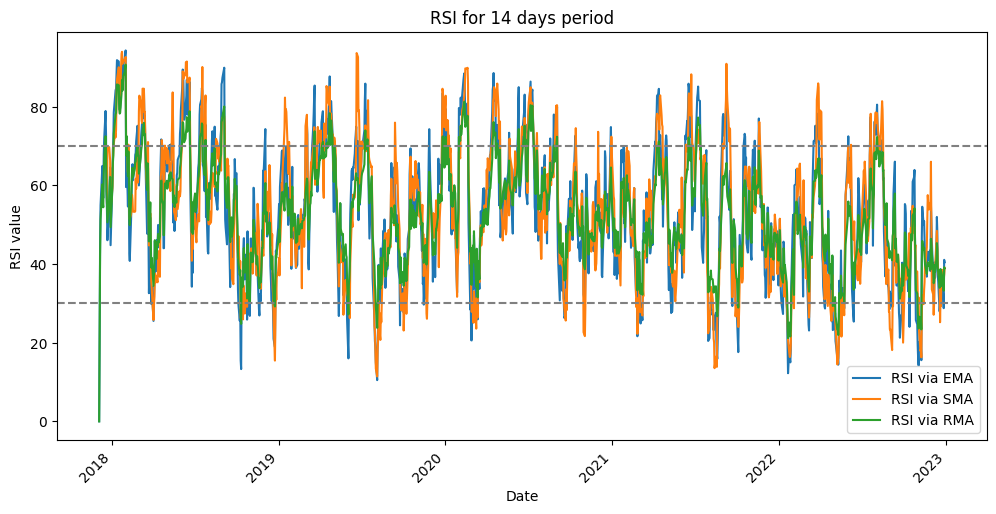

In [5]:
plt.figure(figsize=(12, 6))
rsi_ema.plot()
rsi_sma.plot()
rsi_rma.plot()
plt.axhline(30, c= (.5,.5,.5), ls='--')
plt.axhline(70, c= (.5,.5,.5), ls='--')
plt.title('RSI for 14 days period')
plt.xlabel('Date')
plt.ylabel('RSI value')
plt.xticks(rotation=45)
plt.legend(['RSI via EMA', 'RSI via SMA', 'RSI via RMA'])
plt.show()

Construct RSI-based and BB-based signals. RSI rules: buy when RSI is below 30 and sell when RSI is above 70. BB rules: buy when price is below lower band and sell when price is above upper band.

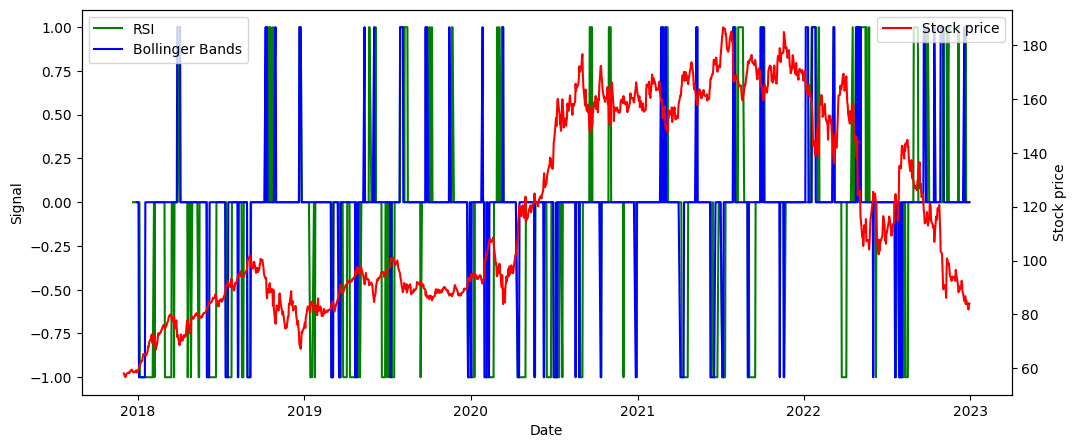

In [15]:
rsi_data = data[['Adj Close', 'rsi']]
bb_data = data[['Adj Close', 'lower_bollinger', 'upper_bollinger']]

def RSI_signal(data: pd.DataFrame):
    
    #short signal
    data['signal'] = np.where(data['rsi'] > 70, -1, np.nan)
    #long signal
    data['signal'] = np.where(data['rsi'] < 30, 1, data['signal'])
    #zero signal
    data['signal'] = np.where((data['rsi'] > 30) & (data['rsi'] < 70), 0, data['signal'])

    return data


def bb_signal(data: pd.DataFrame):
    
    #short signal
    data['signal'] = np.where(data['Adj Close'] > data['upper_bollinger'], -1, np.nan)
    #long signal
    data['signal'] = np.where(data['Adj Close'] < data['lower_bollinger'], 1, data['signal'])
    #zero signal
    data['signal'] = np.where((data['Adj Close'] < data['upper_bollinger']) & (data['Adj Close'] > data['lower_bollinger']), 0, data['signal'])

    return data


rsi_signal = RSI_signal(rsi_data)
bb_signal = bb_signal(bb_data)

fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()
ax1.plot(rsi_signal['signal'], c='g')
ax1.plot(bb_signal['signal'], c='b')
ax2.plot(data['Adj Close'], c='r')
ax1.set_xlabel('Date')
ax1.set_ylabel('Signal')
ax2.set_ylabel('Stock price')
plt.xticks(rotation=45)
ax1.legend(['RSI', 'Bollinger Bands'])
ax2.legend(['Stock price'])
plt.show()

Backtest 1: Backtest both strategies using RSI-based and BB-based signals and vizualize results.

------------------------------------
RSI strategy returns: 0.5987872608437943
Bollinger Bands strategy returns: -0.2365917829861246
------------------------------------


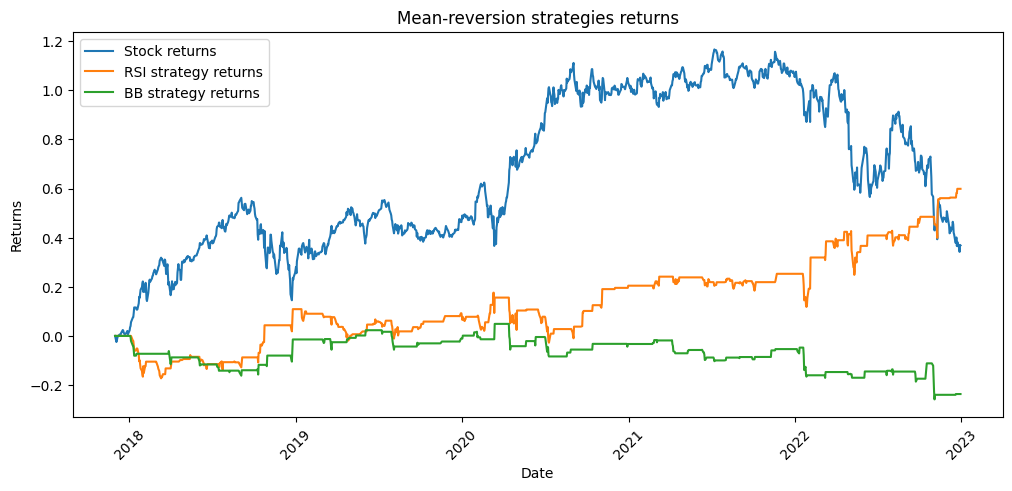

In [18]:
def backtest_strategy(data: pd.DataFrame):
    
    #calculate position and strategy returns, tarding the next day after signal
    data['log_returns'] = np.log(data['Adj Close']).diff()
    data['position'] = data['signal'].ffill()
    data['strategy_returns'] = data['position'].shift(1) * data['log_returns']  
    
    return data

rsi_strategy = backtest_strategy(rsi_signal).fillna(0)
bb_strategy = backtest_strategy(bb_signal).fillna(0)

print('------------------------------------')
print("RSI strategy returns:", rsi_strategy['strategy_returns'].cumsum()[-1])
print("Bollinger Bands strategy returns:", bb_strategy['strategy_returns'].cumsum()[-1])
print('------------------------------------')

plt.figure(figsize=(12,5))
plt.plot(rsi_strategy.index, rsi_strategy['log_returns'].cumsum(), label = 'Stock returns')
plt.plot(rsi_strategy.index, rsi_strategy['strategy_returns'].cumsum(), label = 'RSI strategy returns')
plt.plot(bb_strategy.index, bb_strategy['strategy_returns'].cumsum(), label = 'BB strategy returns')
plt.title('Mean-reversion strategies returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Backtest 2: using external 'backtesting' module for comparison with first method.

Stat                 Mean Reversion - RSI    Mean Reversion - Bollinger Bands
-------------------  ----------------------  ----------------------------------
Start                2017-11-30              2017-11-30
End                  2022-12-30              2022-12-30
Risk-free rate       0.00%                   0.00%

Total Return         70.69%                  -22.91%
Daily Sharpe         0.64                    -0.39
Daily Sortino        1.12                    -0.55
CAGR                 11.10%                  -4.99%
Max Drawdown         -20.22%                 -27.72%
Calmar Ratio         0.55                    -0.18

MTD                  3.88%                   0.32%
3m                   14.92%                  -6.05%
6m                   20.47%                  -8.89%
YTD                  40.16%                  -16.88%
1Y                   40.16%                  -16.88%
3Y (ann.)            16.69%                  -7.80%
5Y (ann.)            11.31%                  -5.08%
1

<Axes: title={'center': 'Backtest result: RSI vs. Bollinger Bands'}>

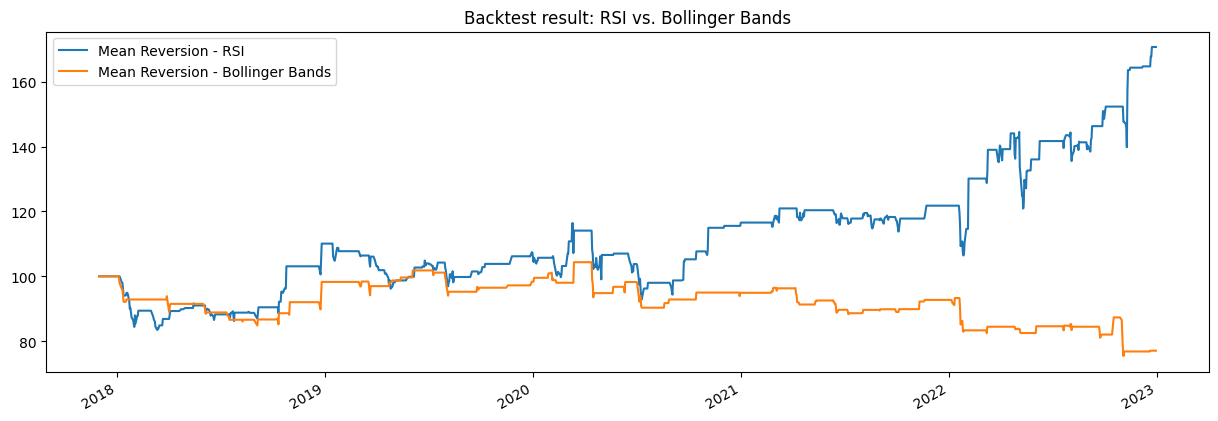

In [8]:
def backtest_strategy_bt(data: pd.DataFrame, signal_name: str, strategy_name: str):
    signal = data[signal_name].astype(float).to_frame().copy()
    signal.rename(columns = {signal_name:'Adj Close'}, inplace = True)
    strategy = bt.Strategy(strategy_name, [bt.algos.WeighTarget(signal), bt.algos.Rebalance()])
    backtest = bt.Backtest(strategy, data)
    
    return backtest

data_bt = data 
data_bt['rsi_signal'] = rsi_signal['signal']
data_bt['bb_signal'] = bb_signal['signal']
backtest_rsi_bt = backtest_strategy_bt(data_bt, 'rsi_signal', "Mean Reversion - RSI")
backtest_bb_bt = backtest_strategy_bt(data_bt, 'bb_signal', "Mean Reversion - Bollinger Bands")

result = bt.run(backtest_rsi_bt, backtest_bb_bt)

#Plot the backtest result
result.display()
result.plot(title='Backtest result: RSI vs. Bollinger Bands')

Backtest 3: Alternative trading approach based on the open position, ie. we can only sell if we have open position. Here one trade is pair of long and short positions.

Long position open at 68.59950256347656 on 2018-04-02 00:00:00
Short position open at 76.37449645996094 on 2018-04-20 00:00:00
Long position open at 87.76249694824219 on 2018-10-10 00:00:00
Short position open at 80.8604965209961 on 2019-01-14 00:00:00
Long position open at 90.77400207519531 on 2019-05-23 00:00:00
Short position open at 95.90950012207031 on 2019-06-20 00:00:00
Long position open at 94.92649841308594 on 2019-07-30 00:00:00
Short position open at 91.96700286865234 on 2019-09-13 00:00:00
Long position open at 86.99199676513672 on 2019-09-26 00:00:00
Short position open at 93.4384994506836 on 2019-12-26 00:00:00
Long position open at 94.1875 on 2020-02-28 00:00:00
Short position open at 108.44349670410156 on 2020-04-13 00:00:00
Long position open at 147.74549865722656 on 2020-09-18 00:00:00
Short position open at 172.18150329589844 on 2020-10-13 00:00:00
Long position open at 151.8074951171875 on 2020-10-30 00:00:00
Short position open at 161.00399780273438 on 2020-12-01 0

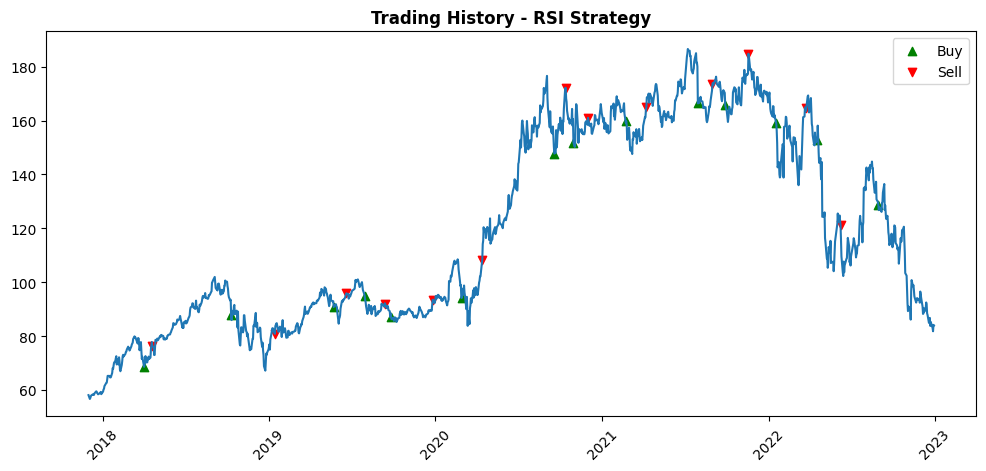

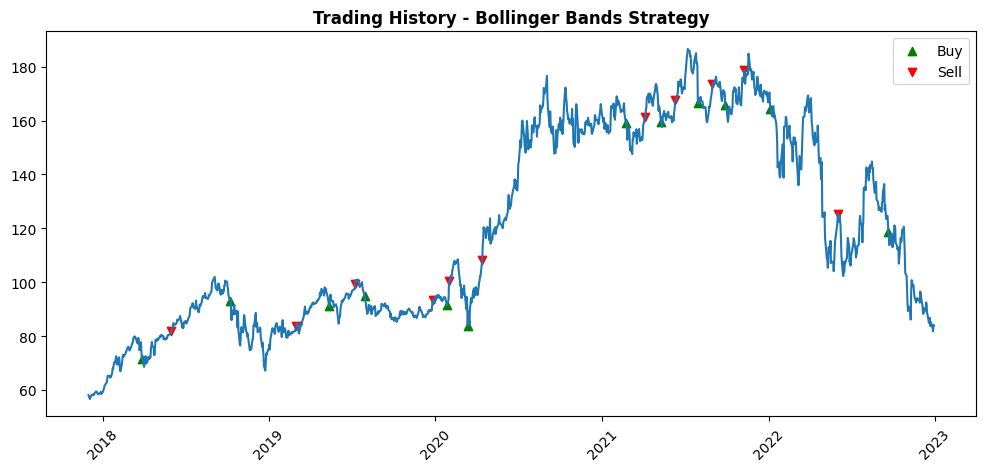

In [9]:
def backtest_strategy_alt(data: pd.DataFrame):
    position = False
    price_change = []

    for i in data.index:
        price = data["Adj Close"][i]
        date = i

        #Long
        if ((data["signal"][i] == 1) & (position == False)):
                buy_price = price
                position = True
                data.at[i, 'buy_date'] = date
                print(f"Long position open at {str(buy_price)} on {str(date)}")

        #short
        if ((data["signal"][i] == -1) & (position == True)):
                sell_price = price
                position = False
                data.at[i, 'sell_date'] = date
                print(f"Short position open at {str(sell_price)} on {str(date)}")

                #Calculate trade profit - difference between long and short position
                change = (sell_price/buy_price)-1
                price_change.append(change)
                
    trades_count = len(price_change)
    won_trades = len([x for x in price_change if x > 0])
    lost_trades = len([x for x in price_change if x < 0])
    
    def calculate_return(total_return, price_change, i):
        
        if i == len(price_change):
            return total_return
        else:
            return calculate_return(total_return * (price_change[i] + 1), price_change, i+1)

    total_return = round((calculate_return(1, price_change, 0)-1)*100, 2)

    print()
    print('--------------------------------')
    print(f"Number of Trades: {trades_count}")
    print(f"Wins: {won_trades}")
    print(f"Losses: {lost_trades}")
    print(f"Total Returns: {total_return}%")
    print()
    

backtest_strategy_alt(rsi_signal)
backtest_strategy_alt(bb_signal)

def show_results(signal_df: pd.DataFrame, strategy_name: str):
    plt.figure(figsize=(12,5))
    plt.xticks(rotation=45)

    plt.plot(signal_df.index, signal_df['Adj Close'])
    plt.scatter(signal_df[(signal_df['signal'] == 1)]['buy_date'], signal_df[(signal_df['signal'] == 1)]['Adj Close'], label = 'Buy', marker='^', c='g')
    plt.scatter(signal_df[(signal_df['signal'] == -1)]['sell_date'], signal_df[(signal_df['signal'] == -1)]['Adj Close'], label = 'Sell', marker='v', c='r')

    plt.title(strategy_name, fontweight="bold")
    plt.legend()
    plt.show()
    
show_results(rsi_signal, 'Trading History - RSI Strategy')
show_results(bb_signal, 'Trading History - Bollinger Bands Strategy')

Alpha research analysis: 

    1) Calculate mean returns and obtain standard error
    2) Calculate Sharpe Ratio
    3) Hypothesis Testing using Student’s t-test - null hypothesis is that the mean return from the signal is 0. Assume alpha (significance level) = 0.05 and reject null hypothesis if p-value < alpha.
    
    'stats.ttest_1samp’ function performs two-sided t-test, so we need to divide p-value by 2 to obtain p-value for one-sided t-test
    we can use omit ^n in 'mean_returns * 252' to calculate annualized rate of return because we computed logarithmic returns before

In [16]:
def analyse_alpha(data: pd.DataFrame, strategy_name: str):
    
    #calculate mean return, standard error and annualized rate of return
    returns_daily = data['strategy_returns']
    mean_return = returns_daily.mean()
    standard_err = returns_daily.sem()
    vol = returns_daily.std() * np.sqrt(252) * 100
    sharpe_annual = mean_return/returns_daily.std() * np.sqrt(252)
    return_annual_rate = (np.exp(mean_return * 252) - 1) * 100
    
    print(strategy_name)
    print('------------------------------------')
    print("""
    Mean:                       {:.6f}
    Standard Error:             {:.6f}
    Annualized volatility:      {:.2f}%
    Annualized Rate of Return:  {:.2f}%
    Annualized Sharpe Ratio:    {:.2f}
    """.format(mean_return, standard_err, vol, return_annual_rate, sharpe_annual))
    
    #analyze alpha, expected mean returns are 0 as in null hypothesis
    t_statistic, p_value = stats.ttest_1samp(returns_daily, 0)
    
    print("""
    Alpha analysis:
     t-statistic:        {:.3f}
     p-value:            {:.6f}
    """.format(t_statistic, p_value/2))

analyse_alpha(rsi_strategy, 'RSI Strategy')
analyse_alpha(bb_strategy, 'Bollinger Bands Strategy')

RSI Strategy
------------------------------------

    Mean:                       0.000468
    Standard Error:             0.000338
    Annualized volatility:      19.20%
    Annualized Rate of Return:  12.52%
    Annualized Sharpe Ratio:    0.61
    

    Alpha analysis:
     t-statistic:        1.385
     p-value:            0.083206
    
Bollinger Bands Strategy
------------------------------------

    Mean:                       -0.000185
    Standard Error:             0.000202
    Annualized volatility:      11.45%
    Annualized Rate of Return:  -4.55%
    Annualized Sharpe Ratio:    -0.41
    

    Alpha analysis:
     t-statistic:        -0.917
     p-value:            0.179672
    


Check the annualized rate of return, volatility and Sharpe Ratio by using external 'pyfolio' module.

C:\Users\piotr\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Start date,2017-12-01
End date,2022-12-30
Total months,60
,Backtest
Annual return,10.5%
Cumulative returns,66.0%
Annual volatility,19.2%
Sharpe ratio,0.61
Calmar ratio,0.53
Stability,0.83
Max drawdown,-19.8%


Start date,2017-12-01
End date,2022-12-30
Total months,60
,Backtest
Annual return,-5.2%
Cumulative returns,-23.7%
Annual volatility,11.5%
Sharpe ratio,-0.41
Calmar ratio,-0.19
Stability,0.31
Max drawdown,-27.8%


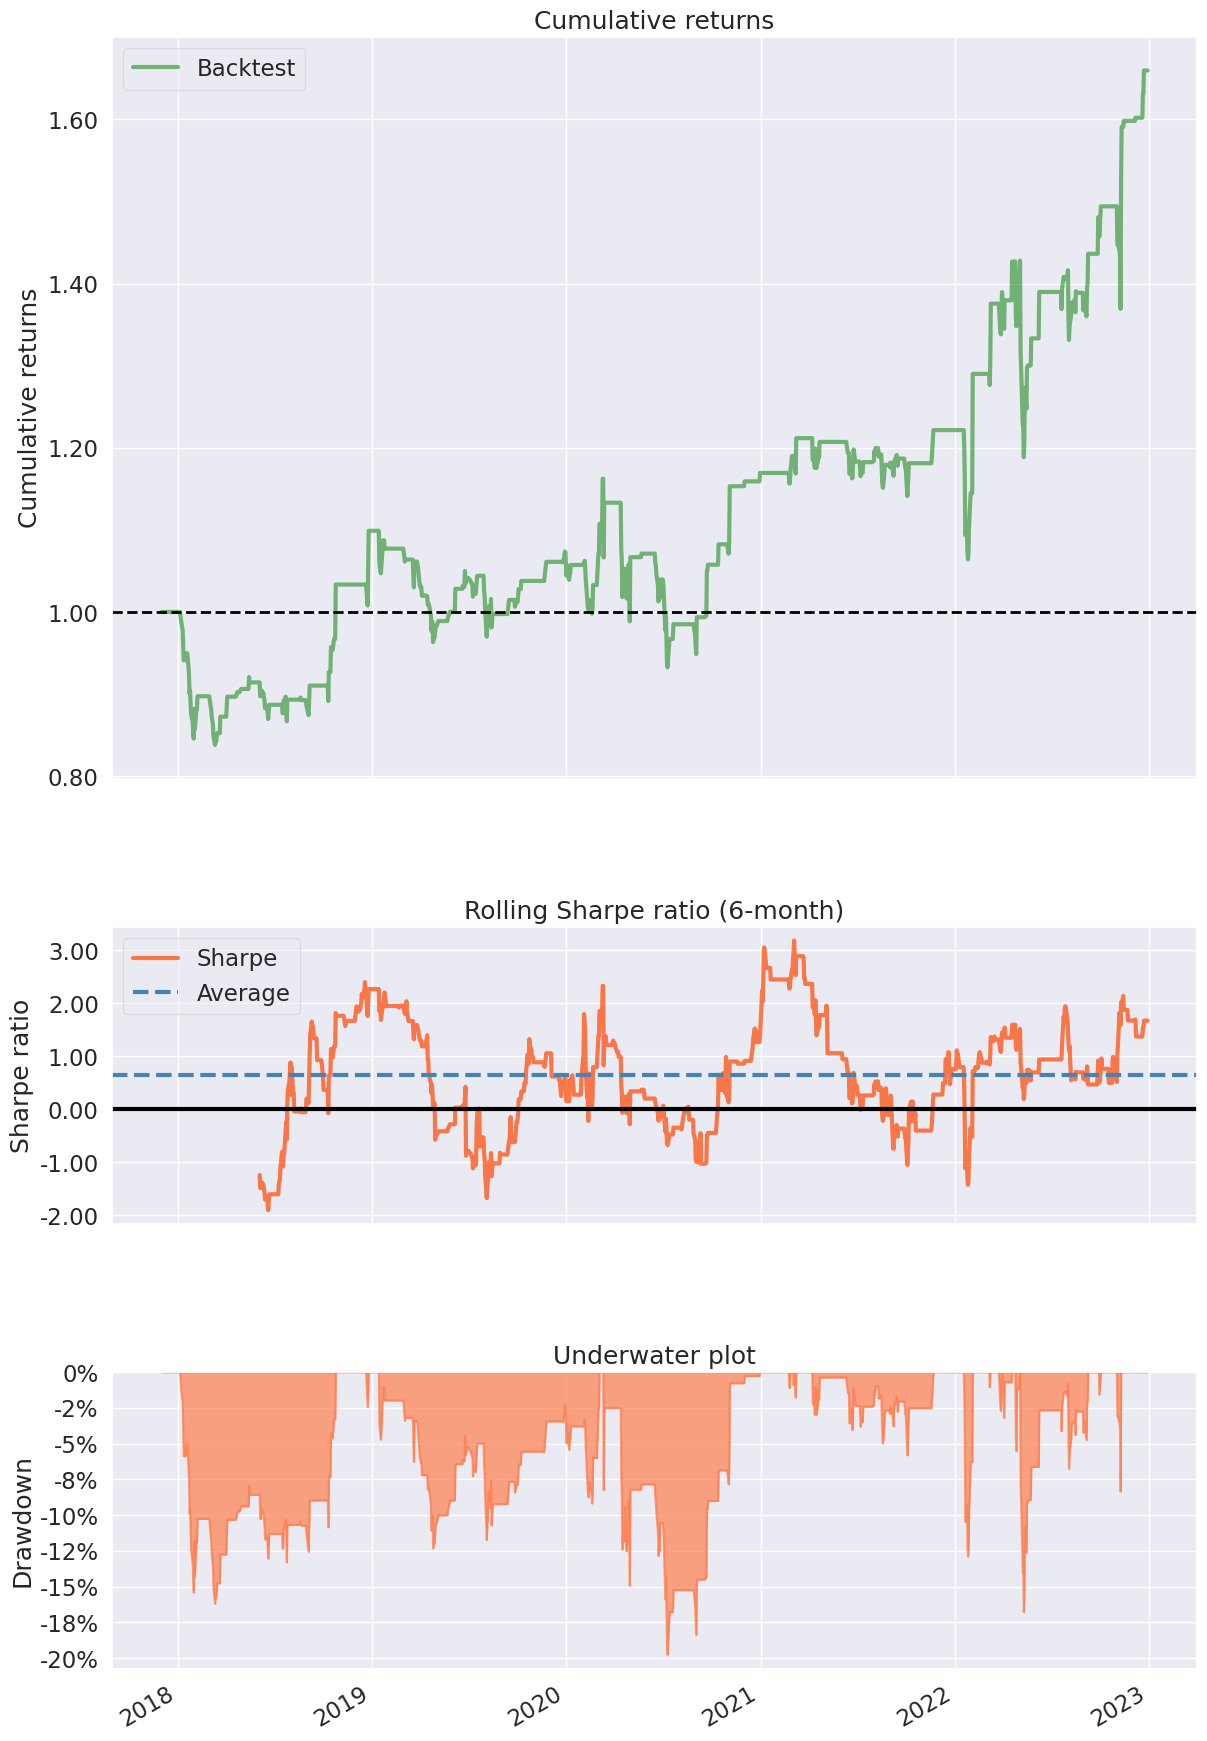

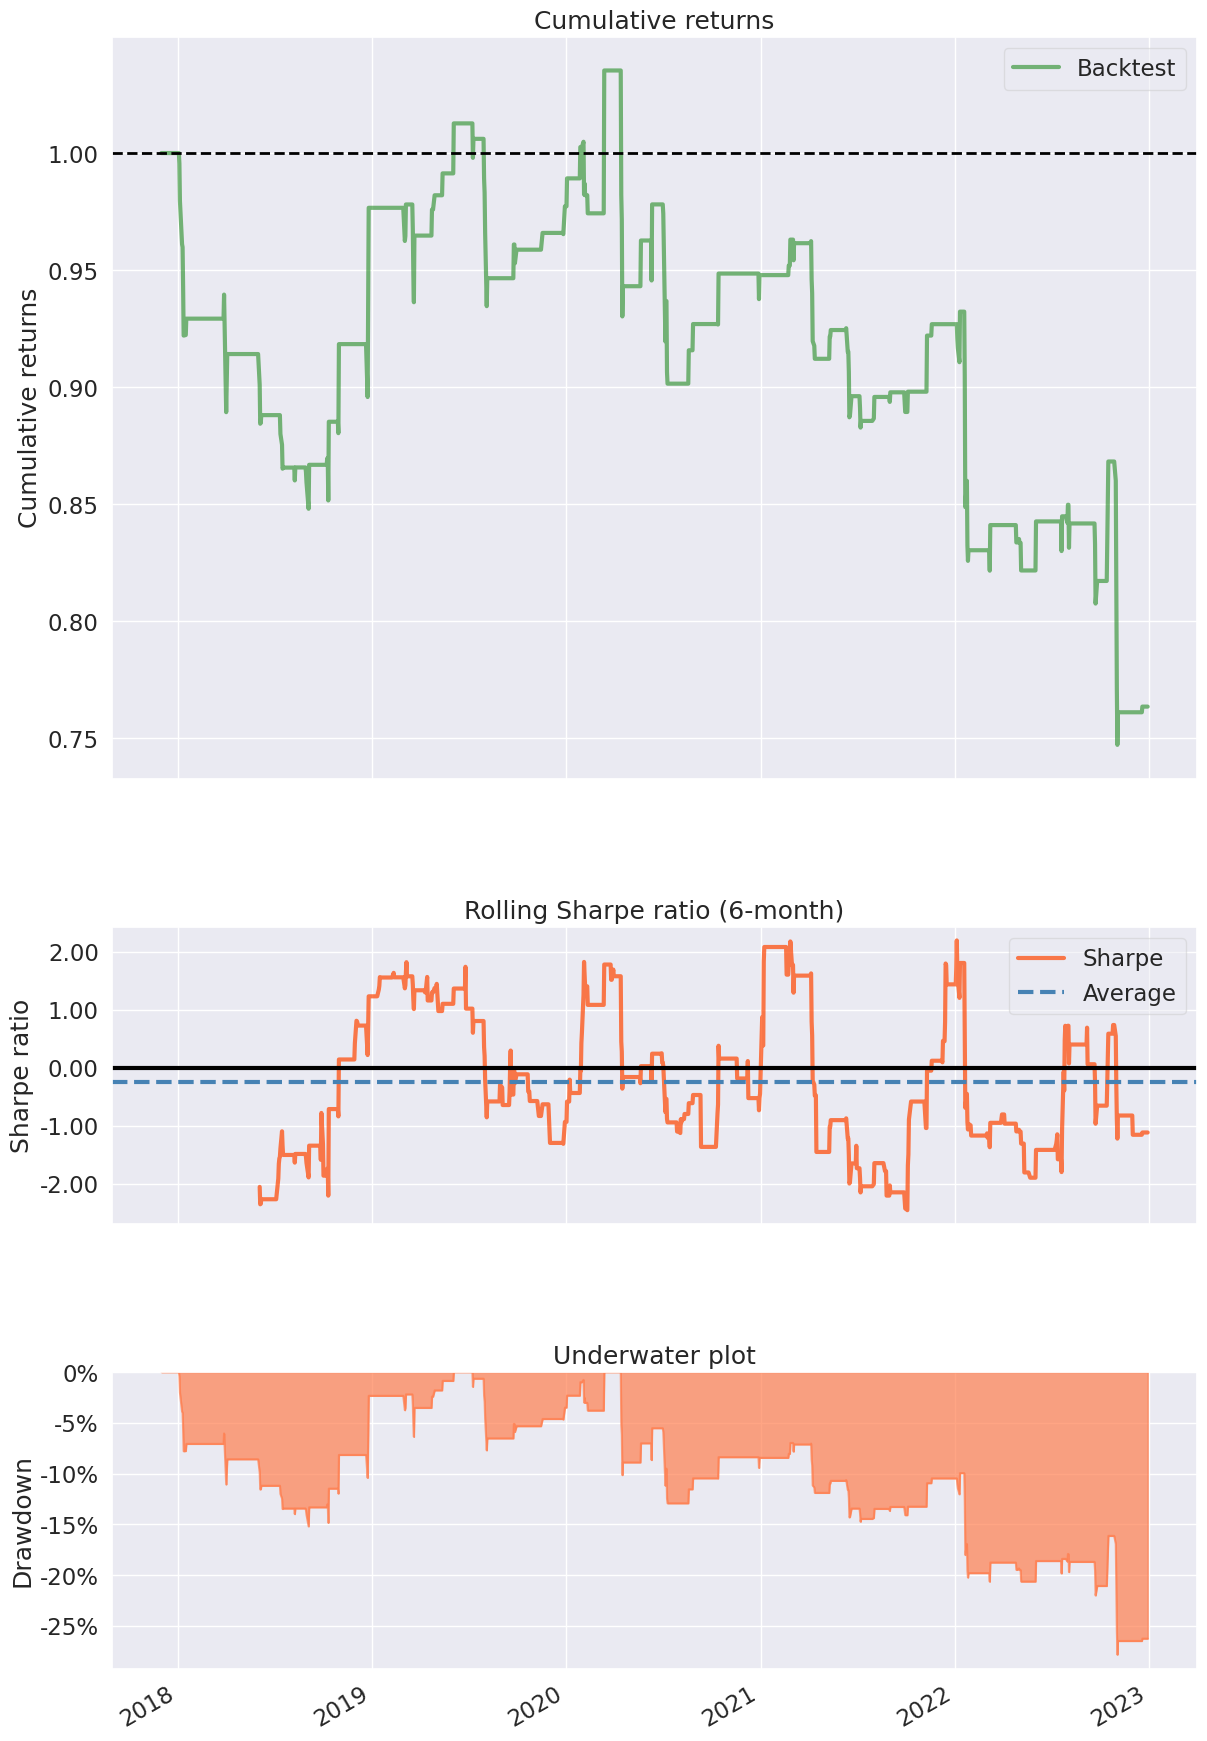

In [12]:
import pyfolio as pf

pf.create_simple_tear_sheet(rsi_strategy['strategy_returns'])
pf.create_simple_tear_sheet(bb_strategy['strategy_returns'])

Now that we have tested our methods we can create a framework for backtesting any strategy. For each new strategy we now only need two things:

    1) method for creating indicators
    2) method for creating signals
Some of them we already wrote above, however they require a bit of modification to fit into our new framework model. Below we backtest three different strategies:

    1) Mean-reversion strategy based on the Bollinger Bands indicator (BB)
    2) Mean-reversion strategy based on the Relative Strength Index calculated using EMA (RSI)
    3) Trend-following strategy based on the Exponential Moving Average (EMA) 

[*********************100%***********************]  1 of 1 completed
RSI 14 days
------------------------------------

    Mean:                       0.000402
    Standard Error:             0.000345
    Annualized volatility:      24.81%
    Annualized Rate of Return:  10.66%
    Annualized Sharpe Ratio:    0.41
    

    Alpha analysis:
     t-statistic:        1.165
     p-value:            0.122119
    


,Open,High,Low,Close,Adj Close,Volume,rsi,signal,log_returns,position,strategy_returns
Date,,,,,,,,,,,
2022-11-04,20.709999,22.330000,20.709999,22.330000,22.330000,150,75.106944,-1.0,0.075797,-1.0,0.000000
2022-11-07,23.290001,23.639999,23.200001,23.639999,23.639999,710,86.956547,-1.0,0.057009,-1.0,-0.057009
2022-11-08,23.440001,24.000000,23.440001,24.000000,24.000000,600,87.762520,-1.0,0.015114,-1.0,-0.015114
2022-11-09,24.080000,24.290001,24.080000,24.290001,24.290001,80,96.504593,-1.0,0.012011,-1.0,-0.012011
2022-11-10,24.190001,24.190001,24.190001,24.190001,24.190001,0,94.581310,-1.0,-0.004125,-1.0,0.004125
2022-11-11,24.980000,25.100000,24.980000,25.100000,25.100000,200,95.132770,-1.0,0.036929,-1.0,-0.036929
2022-11-14,25.490000,27.070000,25.490000,27.070000,27.070000,437,98.020975,-1.0,0.075558,-1.0,-0.075558
2022-11-15,26.770000,26.770000,26.770000,26.770000,26.770000,0,94.619374,-1.0,-0.011144,-1.0,0.011144
2022-11-16,25.270000,25.270000,25.270000,25.270000,25.270000,150,78.702722,-1.0,-0.057664,-1.0,0.057664


------------------------------------
RSI 14 days strategy returns: 0.82%
------------------------------------


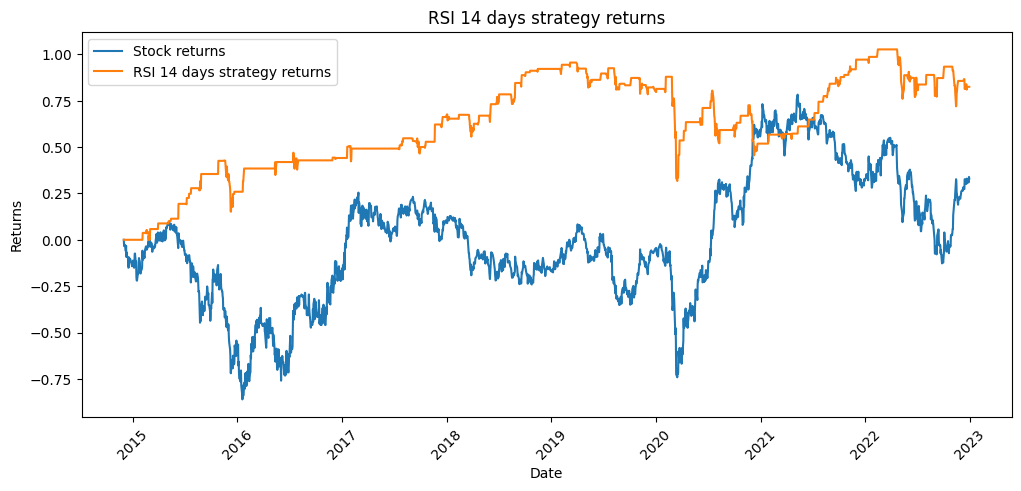

[*********************100%***********************]  1 of 1 completed
Bollinger Bands 20 days
------------------------------------

    Mean:                       0.000140
    Standard Error:             0.000420
    Annualized volatility:      15.38%
    Annualized Rate of Return:  3.59%
    Annualized Sharpe Ratio:    0.23
    

    Alpha analysis:
     t-statistic:        0.333
     p-value:            0.369577
    


,Open,High,Low,Close,Adj Close,Volume,sma,std,upper_bollinger,lower_bollinger,signal,log_returns,position,strategy_returns
Date,,,,,,,,,,,,,,
2022-11-04,20.709999,22.330000,20.709999,22.330000,22.330000,150,19.37725,1.053511,21.484272,17.270228,-1.0,0.075797,-1.0,0.000000
2022-11-07,23.290001,23.639999,23.200001,23.639999,23.639999,710,19.61500,1.412092,22.439183,16.790817,-1.0,0.057009,-1.0,-0.057009
2022-11-08,23.440001,24.000000,23.440001,24.000000,24.000000,600,19.89750,1.684573,23.266645,16.528354,-1.0,0.015114,-1.0,-0.015114
2022-11-09,24.080000,24.290001,24.080000,24.290001,24.290001,80,20.19600,1.904861,24.005723,16.386277,-1.0,0.012011,-1.0,-0.012011
2022-11-10,24.190001,24.190001,24.190001,24.190001,24.190001,0,20.48825,2.048865,24.585979,16.390521,0.0,-0.004125,0.0,0.004125
2022-11-11,24.980000,25.100000,24.980000,25.100000,25.100000,200,20.79700,2.255718,25.308436,16.285564,0.0,0.036929,0.0,0.000000
2022-11-14,25.490000,27.070000,25.490000,27.070000,27.070000,437,21.18075,2.626952,26.434654,15.926846,-1.0,0.075558,-1.0,0.000000
2022-11-15,26.770000,26.770000,26.770000,26.770000,26.770000,0,21.57950,2.842206,27.263912,15.895088,0.0,-0.011144,0.0,0.011144
2022-11-16,25.270000,25.270000,25.270000,25.270000,25.270000,150,21.90375,2.876331,27.656413,16.151087,0.0,-0.057664,0.0,-0.000000


------------------------------------
Bollinger Bands 20 days strategy returns: 0.07%
------------------------------------


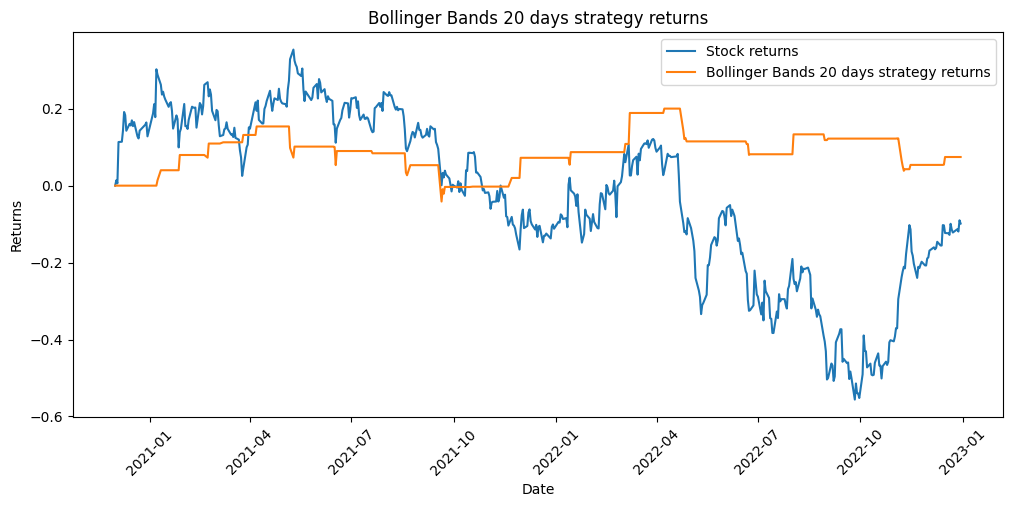

[*********************100%***********************]  1 of 1 completed
EMA Crossover 50, 200
------------------------------------

    Mean:                       -0.000034
    Standard Error:             0.000741
    Annualized volatility:      53.26%
    Annualized Rate of Return:  -0.86%
    Annualized Sharpe Ratio:    -0.02
    

    Alpha analysis:
     t-statistic:        -0.046
     p-value:            0.481472
    


,Open,High,Low,Close,Adj Close,Volume,ema_short,ema_long,signal,log_returns,position,strategy_returns
Date,,,,,,,,,,,,
2022-11-04,20.709999,22.330000,20.709999,22.330000,22.330000,150,19.828267,23.677285,-1.0,0.075797,-1.0,-0.075797
2022-11-07,23.290001,23.639999,23.200001,23.639999,23.639999,710,19.977747,23.676914,-1.0,0.057009,-1.0,-0.057009
2022-11-08,23.440001,24.000000,23.440001,24.000000,24.000000,600,20.135482,23.680129,-1.0,0.015114,-1.0,-0.015114
2022-11-09,24.080000,24.290001,24.080000,24.290001,24.290001,80,20.298404,23.686197,-1.0,0.012011,-1.0,-0.012011
2022-11-10,24.190001,24.190001,24.190001,24.190001,24.190001,0,20.451016,23.691210,-1.0,-0.004125,-1.0,0.004125
2022-11-11,24.980000,25.100000,24.980000,25.100000,25.100000,200,20.633329,23.705228,-1.0,0.036929,-1.0,-0.036929
2022-11-14,25.490000,27.070000,25.490000,27.070000,27.070000,437,20.885748,23.738708,-1.0,0.075558,-1.0,-0.075558
2022-11-15,26.770000,26.770000,26.770000,26.770000,26.770000,0,21.116503,23.768870,-1.0,-0.011144,-1.0,0.011144
2022-11-16,25.270000,25.270000,25.270000,25.270000,25.270000,150,21.279385,23.783807,-1.0,-0.057664,-1.0,0.057664


------------------------------------
EMA Crossover 50, 200 strategy returns: -0.07%
------------------------------------


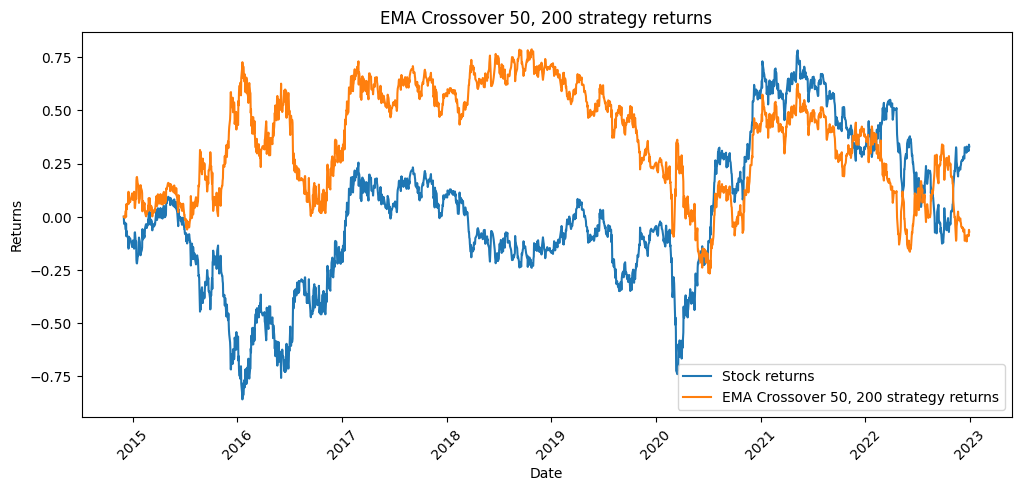

In [18]:
#create indicators
def create_bb_indicator(data: pd.DataFrame, kwargs):
    
    data['sma'] = data['Adj Close'].rolling(kwargs['loopback']).mean()
    data['std'] = data['Adj Close'].rolling(kwargs['loopback']).std()
    data['upper_bollinger'] = data['sma'] + (2 * data['std'])
    data['lower_bollinger'] = data['sma'] - (2 * data['std'])
    
    return data

def create_rsi_indicator(data: pd.DataFrame, kwargs):
    
    prices = data['Adj Close']
    price_delta = prices.diff()
    price_delta = price_delta[1:] 
    gain, loss = price_delta.clip(lower=0), price_delta.clip(upper=0).abs()
    loopback_gain = gain.rolling(kwargs['loopback']).mean()
    loopback_loss = loss.rolling(kwargs['loopback']).mean()
    rs = loopback_gain/loopback_loss
    rsi = 100-(100/(rs+1))
    data['rsi'] = rsi
    
    return data

def create_ema_indicator(data: pd.DataFrame, kwargs):
    
    data['ema_short'] = data['Adj Close'].ewm(span=kwargs['short_term']).mean()
    data['ema_long'] = data['Adj Close'].ewm(span=kwargs['long_term']).mean()
    
    return data

#create signals
def create_bb_signal(data: pd.DataFrame):
    
    #short signal
    data['signal'] = np.where(data['Adj Close'] > data['upper_bollinger'], -1, np.nan)
    #long signal
    data['signal'] = np.where(data['Adj Close'] < data['lower_bollinger'], 1, data['signal'])
    #zero signal
    data['signal'] = np.where((data['Adj Close'] < data['upper_bollinger']) & (data['Adj Close'] > data['lower_bollinger']), 0, data['signal'])

    return data

def create_rsi_signal(data: pd.DataFrame):
    
    #short signal
    data['signal'] = np.where(data['rsi'] > 70, -1, np.nan)
    #long signal
    data['signal'] = np.where(data['rsi'] < 30, 1, data['signal'])
    #zero signal
    data['signal'] = np.where((data['rsi'] > 30) & (data['rsi'] < 70), 0, data['signal'])

    return data

def create_ema_signal(data: pd.DataFrame):
    
    #short signal
    data['signal'] = np.where(data['ema_short'] < data['ema_long'], -1, np.nan)
    #long signal
    data['signal'] = np.where(data['ema_short'] > data['ema_long'], 1, data['signal'])

    return data

def backtesting_framework(strategy_name: str, indicator_function: callable, signal_function: callable, ticker: str, start_date: str, end_date: str, **kwargs):
    data = yf.download(ticker, start=start_date, end=end_date)
    data_indicator = indicator_function(data, kwargs)
    data_signal = signal_function(data_indicator)
    data_strategy = backtest_strategy(data_signal).fillna(0)
    analyse_alpha(data_strategy, strategy_name)
    display(strategy_name.tail(40))    
    print('------------------------------------')
    print(strategy_name+" strategy returns: {:.2f}%".format(data_strategy['strategy_returns'].cumsum()[-1]))
    print('------------------------------------')

    plt.figure(figsize=(12,5))
    plt.plot(data_strategy.index, data_strategy['log_returns'].cumsum(), label = 'Stock returns')
    plt.plot(data_strategy.index, data_strategy['strategy_returns'].cumsum(), label = strategy_name +' strategy returns')
    plt.title(strategy_name+' strategy returns')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    

#backtest Mean-reversion strategy based on the Relative Strength Index indicator
backtesting_framework('RSI 14 days', create_rsi_indicator, create_rsi_signal, 'KGHA.F', '2014-12-01', '2022-12-31', loopback=14)
#backtest Mean-reversion strategy bassed on the Bollinger Bands indicator
backtesting_framework('Bollinger Bands 20 days', create_bb_indicator, create_bb_signal, 'KGHA.F', '2020-12-01', '2022-12-31', loopback=20)
#backtest Trend-following strategy based on Exponential Moving Average indicator
backtesting_framework('EMA Crossover 50, 200', create_ema_indicator, create_ema_signal, 'KGHA.F', '2014-12-01', '2022-12-31', short_term=50, long_term=200)